Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import LinearRegression
from sklearn.tree            import DecisionTreeRegressor 
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import f1_score
from sklearn.metrics         import roc_auc_score

from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import OneHotEncoder

import warnings

In [2]:
#data = pd.read_csv('Churn.csv')
data = pd.read_csv('/datasets/Churn.csv') # для запуска в Практикуме 

Посмотрим, как выглядят данные:

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Напомним, что означают признаки:
- RowNumber — индекс строки в данных

- CustomerId — уникальный идентификатор клиента

- Surname — фамилия

- CreditScore — кредитный рейтинг

- Geography — страна проживания

- Gender — пол

- Age — возраст

- Tenure — количество недвижимости у клиента

- Balance — баланс на счёте

- NumOfProducts — количество продуктов банка, используемых клиентом

- HasCrCard — наличие кредитной карты

- IsActiveMember — активность клиента

- EstimatedSalary — предполагаемая зарплата

`RowNumber`, `CustomerId` и `Surname` не представляют важности для разработки модели, поэтому удалим эти столбцы

In [5]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [6]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Кодирование методом OHE

Избегая дамми-ловушек, преобразуем методом OHE категориальные переменные `Geography` и `Gender`:

In [7]:
data = pd.get_dummies(data, drop_first=True) 

Как теперь выглядят данные:

In [8]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Заполнение пропусков в столбце Tenure

Как можно было заметить, единственный столбец с пропусками – `Tenure`.

Изучим его подробнее: построим график зависимости ухода клиентов (Exited) от количества недвижимости (Tenure).

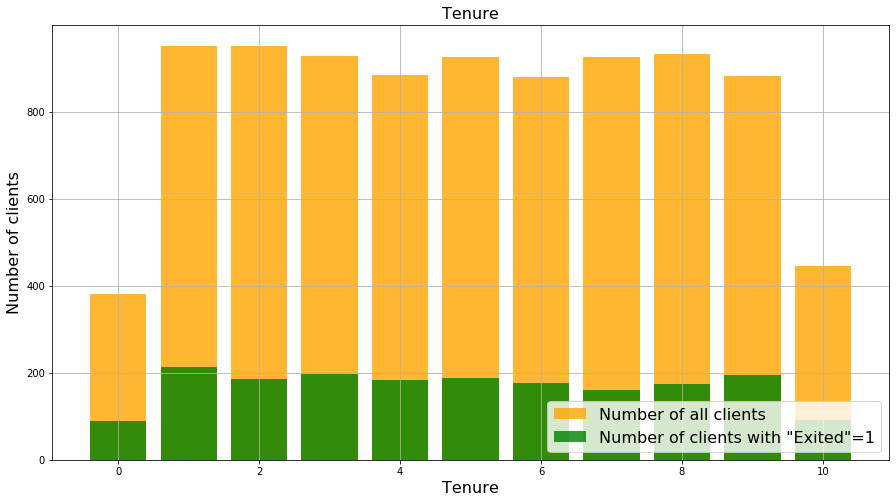

In [9]:
tenure_1 = data[data['Exited']==1]['Tenure'].value_counts()
tenure_0 = data[data['Exited']==0]['Tenure'].value_counts()


plt.figure(figsize=(15,8))
plt.xlabel('Tenure', fontsize=16)
plt.ylabel('Number of clients', fontsize=16)
plt.title('Tenure',fontsize=16);
plt.bar(data['Tenure'].value_counts().index,
        data['Tenure'].value_counts().values,
        color='orange', alpha=0.8, label='Number of all clients')
plt.bar(tenure_1.index,
        tenure_1.values,
        color='g', alpha=0.8, label='Number of clients with "Exited"=1')
plt.grid(True)
plt.legend(loc='lower right', fontsize=16)
plt.show()

Так же посмотрим, как сейчас распределено Tenure по значениям (включая NaN):

In [10]:
data['Tenure'].value_counts(dropna=False).sort_index(ascending = False)

10.0    446
9.0     882
8.0     933
7.0     925
6.0     881
5.0     927
4.0     885
3.0     928
2.0     950
1.0     952
0.0     382
NaN     909
Name: Tenure, dtype: int64

Подозрительно мало значений 0 – без недвижимости. 
___
Посмотрим на то, может ли этот признак зависеть от других.

Признаки, которые могут определять Tenure и их корреляция:

In [11]:
data[[ 'CreditScore' , 'Age' , 'Balance' , 'EstimatedSalary']].corr()

,CreditScore,Age,Balance,EstimatedSalary
CreditScore,1.000000,-0.003965,0.006268,-0.001384
Age,-0.003965,1.000000,0.028308,-0.007201
Balance,0.006268,0.028308,1.000000,0.012797
EstimatedSalary,-0.001384,-0.007201,0.012797,1.000000


Корреляция очень низкая – тогда эти переменные не определяют количество квартир.

Тогда удалять этот признак нельзя. Предположим, что пропуски – это отсутсвие недвижимости, заполним их нулём.

In [12]:
data['Tenure'] = data['Tenure'].fillna(0)

Посмотрим, остались ли пропуски:

In [13]:
np.isnan(data).sum()

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
dtype: int64

### Масштабирование признаков


Масштабируем количественные признаки:

In [14]:
scaler = StandardScaler()
scaled_values = scaler.fit_transform(data[['CreditScore', 'Age' , 'Balance' , 'EstimatedSalary']])
data_scaled = pd.DataFrame(data = scaled_values ,
                           columns = data[['CreditScore', 'Age' , 'Balance' , 'EstimatedSalary']].columns )
data_scaled.head()

,CreditScore,Age,Balance,EstimatedSalary
0,-0.326221,0.293517,-1.225848,0.021886
1,-0.440036,0.198164,0.117350,0.216534
2,-1.536794,0.293517,1.333053,0.240687
3,0.501521,0.007457,-1.225848,-0.108918
4,2.063884,0.388871,0.785728,-0.365276


Объединим масштабированные ранее признаки с остальными и выделим target:

In [15]:
features = pd.concat([data.drop(['CreditScore', 'Age' , 'Balance' , 'EstimatedSalary', 'Exited'], axis = 1) , 
                     data_scaled] , axis = 1)
target = data['Exited']

print(features.shape)
print(target.shape)

(10000, 11)
(10000,)


### Вывод:

Изначально данные содержали 14 признаков (один из них – целевой)

После анализа было установлено, что такие признаки, как `RowNumber`, `CustomerId`, `Surname` не несут смысловой нагрузки для дальнейшего построения модели. Поэтому они были удалены.

Далее, с помощью метода `info()` было определено наличие пропусков в столбце `Tenure`. 

Для анализа `Tenure` был построен график, показывающиq общее количество клиентов с недвижимостью и ушедших клиентов. 

Распределение `Tenure` по значениям приблизительно одинаковое – ~20%. Было принято решение заполнить пропуски нулём, предположив, что отсутствующие значения – это экземпляры без недвижимости.

Количественные признаки были масштабированы методом `Standardscaler()`.

Категориальные признаки были преобразованы  методом OHE.

Методом `concat()` все преобразованные и исходные признаки объединены в один датафрейм `features`.

✅ Итого 11 признаков в `features` и 1 в `target`. Оба длиной 10000.

## 2. Исследование задачи


Распределение значений в целевом признаке:

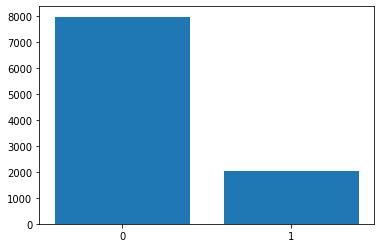

In [16]:
plt.bar(target.value_counts().index, target.value_counts().values)
plt.xticks(np.arange(0, 1.1, step=1))
plt.show()

Это даёт предположение о том, что классы не сбалансированны 😬

### Разделение на train/valid/test
Делим данные на обучающую/валидационную/тестовую выборки в соотношении 60%/20%/20% соответственно:

In [17]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

Посмотрим на размерности и удостоверимся, что всё сделано, как надо ☺️

In [18]:
features_train.name = 'features_train'
features_valid.name = 'features_valid'
features_test.name = 'features_test'
target_train.name = 'target_train'
target_valid.name = 'target_valid'
target_test.name = 'target_test'

for data in [features_train, features_valid, features_test, target_train, target_valid, target_test]:
    print(f"Shape of {data.name}:{np.shape(data)}")
    if 'test' in data.name:
        print()

Shape of features_train:(6000, 11)
Shape of features_valid:(2000, 11)
Shape of features_test:(2000, 11)

Shape of target_train:(6000,)
Shape of target_valid:(2000,)
Shape of target_test:(2000,)



Функция, которая упростит дальнейшую работу по исследованию различных моделей:

In [19]:
def model(name_of_model, type_of_model,
         features, target):
    
    model = type_of_model
    model.fit(features, target)
    predicted_valid = model.predict(features_valid)

    accuracy = accuracy_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)

    probabilities = model.predict_proba(features_valid)
    probabilities_one = probabilities[:, 1]
    ROCAUC = roc_auc_score(target_valid, probabilities_one)

    print(name_of_model)
    print("Accuracy =", '{:.4f}'.format(round(accuracy,4)), 
          "F1 Score =", '{:.4f}'.format(round(F1,4)),
          "ROC-AUC  =", '{:.4f}'.format(round(ROCAUC,4)))
    #print("F1 Score =", '{:.4f}'.format(round(F1,4)))
    #print("ROC-AUC  =", '{:.4f}'.format(round(ROCAUC,4)))

### DecisionTreeClassifier

In [20]:
model('Random tree', DecisionTreeClassifier(random_state=12345), features_train, target_train)

Random tree
Accuracy = 0.7915 F1 Score = 0.4970 ROC-AUC  = 0.6816


### LogisticRegression

In [21]:
model('Логистическая регрессия', LogisticRegression(random_state=12345, solver='liblinear'), 
      features_train, target_train)

Логистическая регрессия
Accuracy = 0.8025 F1 Score = 0.3339 ROC-AUC  = 0.7586


In [22]:
model('Логистическая регрессия',
      LogisticRegression(random_state=12345, class_weight = 'balanced', solver='liblinear'), 
      features_train, target_train)

Логистическая регрессия
Accuracy = 0.7010 F1 Score = 0.4889 ROC-AUC  = 0.7636


Можно предположить, что классы не сбалансированны

### RandomForestClassifier

In [23]:
model('Случайный лес', RandomForestClassifier(random_state=12345, n_estimators = 10), 
      features_train, target_train)

Случайный лес
Accuracy = 0.8500 F1 Score = 0.5468 ROC-AUC  = 0.8053


### Вывод:
Классы целевого признака не сбалансированы из-за того, что количнество Exited=1 значительно меньше Exited=0 (показано на диаграмме).

Методом `train_test_split()` данные были разбиты на 3 выборки: обучающую, валидационную, тестовую. Отношение размера выборок $0.6/0.2/0.2$.

Опробованные модели:

- Решающее дерево: F1 = 0.497

- Логистическая регрессия: F1 = 0.33 (без учета баланса классов)

- Логистическая регрессия: F1 = 0.49 (с учетом баланса классов)

- Случайный лес: F1 = 0.55 при n_estimators = 10. 

Для улучшения модели необходимо провести балансировку классов.

## 3. Устранение дисбаланса классов

Функция апсэмплинга увеличит наши выборки:

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return features_upsampled, target_upsampled

In [25]:
for repeat in range(1,15):
    print('Repeat', repeat)
    model('', RandomForestClassifier(random_state=12345, n_estimators = 10),
         upsample(features_train, target_train, repeat)[0], upsample(features_train, target_train, repeat)[1])
    print()

Repeat 1

Accuracy = 0.8500 F1 Score = 0.5536 ROC-AUC  = 0.8070

Repeat 2

Accuracy = 0.8455 F1 Score = 0.5726 ROC-AUC  = 0.8058

Repeat 3

Accuracy = 0.8420 F1 Score = 0.5635 ROC-AUC  = 0.8139

Repeat 4

Accuracy = 0.8375 F1 Score = 0.5566 ROC-AUC  = 0.8161

Repeat 5

Accuracy = 0.8350 F1 Score = 0.5600 ROC-AUC  = 0.8091

Repeat 6

Accuracy = 0.8410 F1 Score = 0.5644 ROC-AUC  = 0.8093

Repeat 7

Accuracy = 0.8415 F1 Score = 0.5745 ROC-AUC  = 0.8119

Repeat 8

Accuracy = 0.8460 F1 Score = 0.5758 ROC-AUC  = 0.7969

Repeat 9

Accuracy = 0.8300 F1 Score = 0.5368 ROC-AUC  = 0.8086

Repeat 10

Accuracy = 0.8440 F1 Score = 0.5829 ROC-AUC  = 0.8104

Repeat 11

Accuracy = 0.8445 F1 Score = 0.5769 ROC-AUC  = 0.8126

Repeat 12

Accuracy = 0.8455 F1 Score = 0.5726 ROC-AUC  = 0.8052

Repeat 13

Accuracy = 0.8450 F1 Score = 0.5694 ROC-AUC  = 0.8176

Repeat 14

Accuracy = 0.8400 F1 Score = 0.5640 ROC-AUC  = 0.8185



Лучший результат F1_score был достигнут при repeat = 10. Оставим его для апсэмплинга.

In [26]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

Запустим случайный лес и выберем наилучшие параметры глубины и количества деревьев:

In [27]:
for estim in range(10, 61, 5):
    for depth in range(6,15):
        model('Случайный лес, ' + 'n_estim = ' + str(estim)+', max_depth = ' +str(depth), 
              RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345),
             features_upsampled, target_upsampled)


Случайный лес, n_estim = 10, max_depth = 6
Accuracy = 0.5750 F1 Score = 0.4720 ROC-AUC  = 0.8433
Случайный лес, n_estim = 10, max_depth = 7
Accuracy = 0.6165 F1 Score = 0.4931 ROC-AUC  = 0.8410
Случайный лес, n_estim = 10, max_depth = 8
Accuracy = 0.6605 F1 Score = 0.5126 ROC-AUC  = 0.8326
Случайный лес, n_estim = 10, max_depth = 9
Accuracy = 0.6845 F1 Score = 0.5273 ROC-AUC  = 0.8259
Случайный лес, n_estim = 10, max_depth = 10
Accuracy = 0.7145 F1 Score = 0.5354 ROC-AUC  = 0.8221
Случайный лес, n_estim = 10, max_depth = 11
Accuracy = 0.7525 F1 Score = 0.5553 ROC-AUC  = 0.8195
Случайный лес, n_estim = 10, max_depth = 12
Accuracy = 0.7685 F1 Score = 0.5586 ROC-AUC  = 0.8145
Случайный лес, n_estim = 10, max_depth = 13
Accuracy = 0.7980 F1 Score = 0.5720 ROC-AUC  = 0.8130
Случайный лес, n_estim = 10, max_depth = 14
Accuracy = 0.8035 F1 Score = 0.5705 ROC-AUC  = 0.8188
Случайный лес, n_estim = 15, max_depth = 6
Accuracy = 0.5695 F1 Score = 0.4669 ROC-AUC  = 0.8412
Случайный лес, n_estim = 

Случайный лес, n_estim = 55, max_depth = 9
Accuracy = 0.6945 F1 Score = 0.5339 ROC-AUC  = 0.8395
Случайный лес, n_estim = 55, max_depth = 10
Accuracy = 0.7390 F1 Score = 0.5613 ROC-AUC  = 0.8387
Случайный лес, n_estim = 55, max_depth = 11
Accuracy = 0.7630 F1 Score = 0.5651 ROC-AUC  = 0.8348
Случайный лес, n_estim = 55, max_depth = 12
Accuracy = 0.7840 F1 Score = 0.5814 ROC-AUC  = 0.8408
Случайный лес, n_estim = 55, max_depth = 13
Accuracy = 0.8095 F1 Score = 0.5925 ROC-AUC  = 0.8345
Случайный лес, n_estim = 55, max_depth = 14
Accuracy = 0.8225 F1 Score = 0.5905 ROC-AUC  = 0.8368
Случайный лес, n_estim = 60, max_depth = 6
Accuracy = 0.5600 F1 Score = 0.4641 ROC-AUC  = 0.8432
Случайный лес, n_estim = 60, max_depth = 7
Accuracy = 0.6160 F1 Score = 0.4934 ROC-AUC  = 0.8462
Случайный лес, n_estim = 60, max_depth = 8
Accuracy = 0.6660 F1 Score = 0.5194 ROC-AUC  = 0.8450
Случайный лес, n_estim = 60, max_depth = 9
Accuracy = 0.6940 F1 Score = 0.5321 ROC-AUC  = 0.8398
Случайный лес, n_estim = 

Наилучшее значенеи F1 Score = 0.598 было достигнуто при n_estim = 50, max_depth = 14

___
Функция для даунсэмплинга:

In [28]:
from sklearn.utils import shuffle
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    

    return features_downsampled, target_downsampled

подберём наилучший параметр repeat:

In [29]:
for repeat in np.arange(0.9, 1.01, 0.01):
    print('Repeat:', repeat)
    features_downsampled, target_downsampled = downsample(features_upsampled, target_upsampled, repeat)
    model('',RandomForestClassifier(random_state=12345, n_estimators=50, max_depth = 14),
          features_downsampled, target_downsampled)
    print()

Repeat: 0.9

Accuracy = 0.8190 F1 Score = 0.6022 ROC-AUC  = 0.8388

Repeat: 0.91

Accuracy = 0.8160 F1 Score = 0.5938 ROC-AUC  = 0.8388

Repeat: 0.92

Accuracy = 0.8175 F1 Score = 0.5913 ROC-AUC  = 0.8360

Repeat: 0.93

Accuracy = 0.8230 F1 Score = 0.6049 ROC-AUC  = 0.8395

Repeat: 0.9400000000000001

Accuracy = 0.8275 F1 Score = 0.6066 ROC-AUC  = 0.8388

Repeat: 0.9500000000000001

Accuracy = 0.8200 F1 Score = 0.5973 ROC-AUC  = 0.8386

Repeat: 0.9600000000000001

Accuracy = 0.8290 F1 Score = 0.6096 ROC-AUC  = 0.8367

Repeat: 0.9700000000000001

Accuracy = 0.8235 F1 Score = 0.6002 ROC-AUC  = 0.8342

Repeat: 0.9800000000000001

Accuracy = 0.8210 F1 Score = 0.5913 ROC-AUC  = 0.8358

Repeat: 0.9900000000000001

Accuracy = 0.8190 F1 Score = 0.5896 ROC-AUC  = 0.8410

Repeat: 1.0

Accuracy = 0.8250 F1 Score = 0.6023 ROC-AUC  = 0.8357



Наилучший F1_score при repeat=0.96 ✅

Используем это далее. Смешаем train и valid и получим из них наборы данных features_upsampled, target_upsampled

In [30]:
features = pd.concat([features_train, features_valid])
target = pd.concat([target_train, target_valid])

features_upsampled, target_upsampled = upsample(features, target, 10)
np.shape(features_upsampled)
#features_downsampled, target_downsampled = downsample(features_upsampled, target_upsampled, 0.96) 

(22526, 11)

### Вывод:

Для корректировки дисбаланса между классами были рассмотрены апсэмплинг и даунсэмплинг.

Было установлено, что для правильного баланса классов нужно сделать upsampling с параметром repeat = 10, downsampling с параметром repeat = 0.96.

Лучшее значение метрики F1 показала модель случайного леса с гиперпараметрами n_estim = 50, max_depth = 14. 

Эта модель станет основной в работе и будет проверяться на тестовой выборке.


## 4. Проверка на тестовой выборке

In [31]:
model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth = 14)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

probabilities = model.predict_proba(features)
probabilities_one = probabilities[:, 1]
accuracy = accuracy_score(target_test, predicted_test)
ROCAUC = roc_auc_score(target, probabilities_one)
F1 = f1_score(target_test, predicted_test)

print("Accuracy =", '{:.4f}'.format(round(accuracy, 4)),
      "ROC-AUC =",  '{:.4f}'.format(round(ROCAUC, 4)), 
      "F1 =", '{:.4f}'.format(round(F1, 4)))

Accuracy = 0.8175 ROC-AUC = 0.9998 F1 = 0.6011


### Вывод:
Для тестирования модели был выбран алгоритм случайного леса, при этом выборка прошла апсэмплинг.

По наибольшему значению F1 score были определены оптимальные значения гиперпараметров: 

- количество деревьев - 50
- глубина дерева - 14

При этом значение метрики F1 составило 0.6011. Accuracy = 0.82

Метрика AUC-ROC составила 0.99, что означает: количество пар объектов {1,0} , которые модель определила правильно, составляет 99%.